# **Baseline**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# ===== THAM SỐ CẤU HÌNH =====
INPUT_LEN = 14      # Số ngày input
OUTPUT_LEN = 3      # Số ngày output mỗi lần dự đoán
TOTAL_PREDICT_DAYS = 100  # Tổng số ngày cần dự đoán

In [ ]:
# Load data train
df_train = pd.read_csv('/content/FPT_train.csv')
df_train['time'] = pd.to_datetime(df_train['time'])
df_train = df_train.sort_values('time').reset_index(drop=True)


# Lấy 5 ngày có close lớn nhất và bé nhất
top_5_close = df_train.nlargest(5, 'close')['close']
bottom_5_close = df_train.nsmallest(5, 'close')['close']

In [ ]:
df_train

,time,open,high,low,close,volume,symbol
0,2020-08-03,19.07,19.63,19.03,19.63,1392200,FPT
1,2020-08-04,19.89,20.01,19.76,19.91,1051310,FPT
2,2020-08-05,19.89,20.16,19.78,20.10,1328520,FPT
3,2020-08-06,20.10,20.21,19.97,20.01,1153660,FPT
4,2020-08-07,20.01,20.44,20.01,20.14,1283690,FPT
...,...,...,...,...,...,...,...
1144,2025-03-04,120.28,121.23,120.11,120.71,3480042,FPT
1145,2025-03-05,120.71,120.80,119.93,119.93,2862185,FPT
1146,2025-03-06,120.28,123.73,120.28,122.09,6428376,FPT
1147,2025-03-07,122.18,123.04,121.66,121.92,2966941,FPT


In [ ]:
top_5_close

,close
1121,133.04
1122,132.26
1105,131.49
1106,131.06
1101,130.02


In [ ]:
bottom_5_close

,close
0,19.63
1,19.91
3,20.01
2,20.10
6,20.10


In [ ]:
# Tạo log transform
df_train['close_log'] = np.log(df_train['close'])

print(f"Train data shape: {df_train.shape}")
print(f"Date range: {df_train['time'].min()} to {df_train['time'].max()}")

print(df_train[['time', 'close', 'close_log']].head())

Train data shape: (1149, 8)
Date range: 2020-08-03 00:00:00 to 2025-03-10 00:00:00
        time  close  close_log
0 2020-08-03  19.63   2.977059
1 2020-08-04  19.91   2.991222
2 2020-08-05  20.10   3.000720
3 2020-08-06  20.01   2.996232
4 2020-08-07  20.14   3.002708


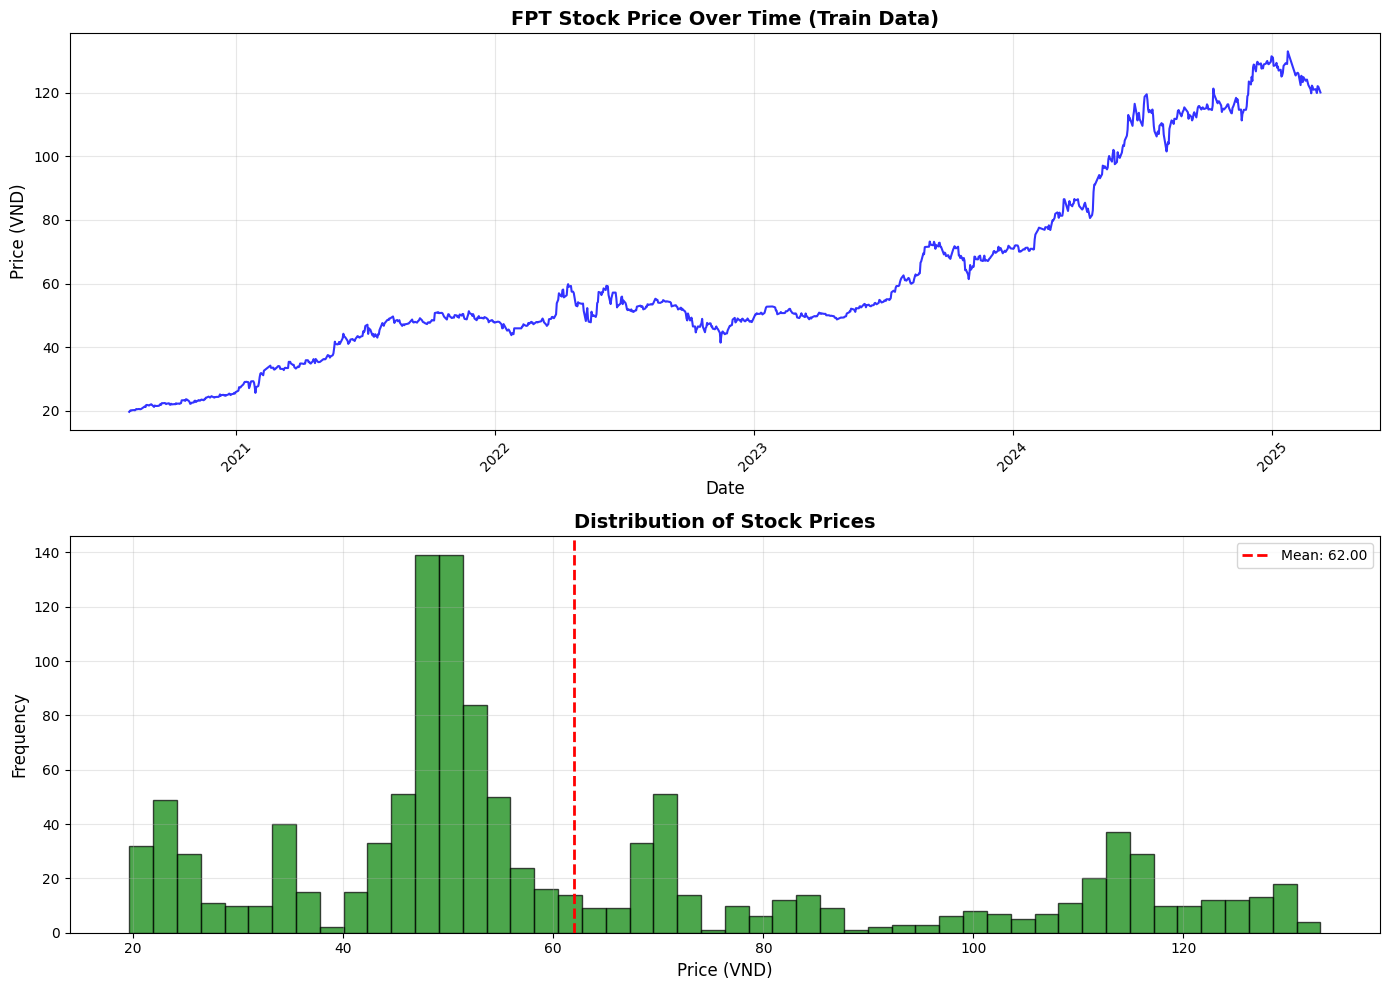

In [ ]:
# ===== PHÂN TÍCH DỮ LIỆU =====
# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Giá close theo thời gian
axes[0].plot(df_train['time'], df_train['close'], linewidth=1.5, color='blue', alpha=0.8)
axes[0].set_title('FPT Stock Price Over Time (Train Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Phân phối giá
axes[1].hist(df_train['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribution of Stock Prices', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Price (VND)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(df_train['close'].mean(), color='red', linestyle='--',
                 linewidth=2, label=f'Mean: {df_train["close"].mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()


Kiểm chứng vụ "DLinear phế vì Seasonality ảo/Nhiễu nhiều"

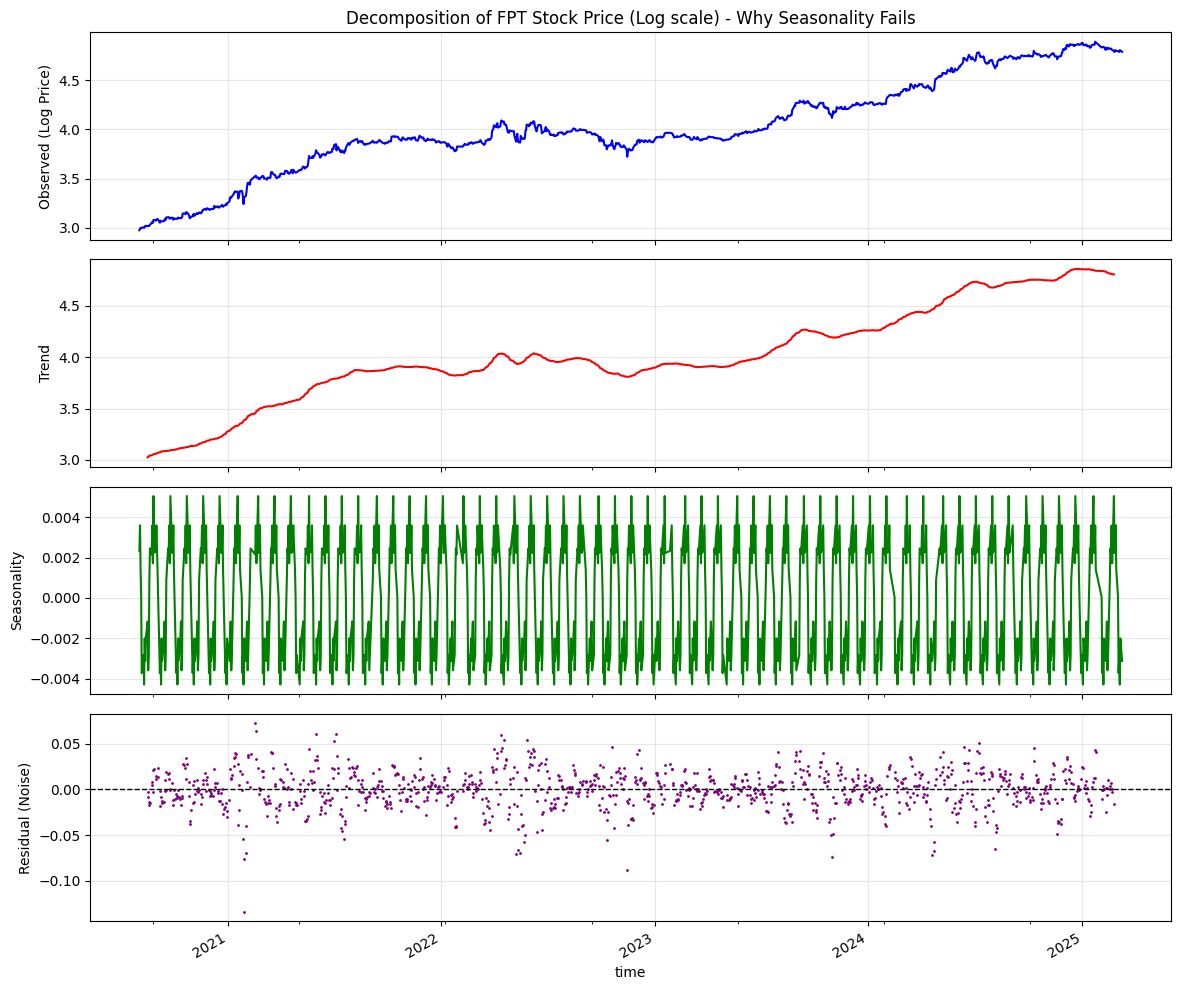

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load và chuẩn bị dữ liệu
df = pd.read_csv('FPT_train.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').sort_index()

# 2. Phân rã chuỗi (Decomposition)
# Lưu ý: Tao Log transform trước để công bằng với logic của bài toán
# model='additive' vì sau khi log, các thành phần thường có tính cộng (Trend + Season + Noise)
# period=20: Giả định chu kỳ lặp lại sau mỗi 20 phiên (khoảng 1 tháng)
result = seasonal_decompose(np.log(df['close']), model='additive', period=20)

# 3. Vẽ đồ thị
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot 1: Giá thực tế (Observed)
result.observed.plot(ax=ax1, color='blue')
ax1.set_ylabel('Observed (Log Price)')
ax1.set_title('Decomposition of FPT Stock Price (Log scale) - Why Seasonality Fails')
ax1.grid(True, alpha=0.3)

# Plot 2: Xu hướng (Trend) - Cái này DLinear bắt tốt
result.trend.plot(ax=ax2, color='red')
ax2.set_ylabel('Trend')
ax2.grid(True, alpha=0.3)

# Plot 3: Mùa vụ (Seasonality) - Cái này là "ảo", biên độ cực bé
result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonality')
ax3.grid(True, alpha=0.3)

# Plot 4: Nhiễu (Residual) - Cái này biên độ to đùng -> Chứng tỏ nhiễu lấn át mùa vụ
result.resid.plot(ax=ax4, color='purple', linestyle='None', marker='.', markersize=2)
ax4.set_ylabel('Residual (Noise)')
ax4.axhline(0, color='black', linestyle='--', linewidth=1)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Linear Model
# class LinearModel(nn.Module):
#     def __init__(self, input_len, output_len):
#         super(LinearModel, self).__init__()
#         self.input_len = input_len
#         self.output_len = output_len
#         self.linear = nn.Linear(input_len, output_len)

#     def forward(self, x):
#         # x: [batch_size, input_len]
#         # output: [batch_size, output_len]
#         return self.linear(x)

# model = LinearModel(INPUT_LEN, OUTPUT_LEN)

class NLinear(nn.Module):
    """Normalized Linear for univariate time series - handles distribution shift"""
    def __init__(self, seq_len, pred_len=7):
        super(NLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # Normalize by subtracting last value
        last_value = x[:, -1:]
        x_normalized = x - last_value
        pred_normalized = self.linear(x_normalized)
        pred = pred_normalized + last_value
        return pred

model = NLinear(INPUT_LEN, OUTPUT_LEN)

In [ ]:
df_train['close_log']

,close_log
0,2.977059
1,2.991222
2,3.000720
3,2.996232
4,3.002708
...,...
1144,4.793391
1145,4.786908
1146,4.804758
1147,4.803365


In [ ]:
# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len, target_col='close_log'):
        self.data = data[target_col].values # chuyển thành array số
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - self.input_len - self.output_len + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_len]
        y = self.data[idx+self.input_len:idx+self.input_len+self.output_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Tạo dataset và dataloader
dataset = TimeSeriesDataset(df_train, INPUT_LEN, OUTPUT_LEN)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset size: {len(dataset)} samples")
print(f"Sample shape: input={INPUT_LEN}, output={OUTPUT_LEN}")

Dataset size: 1133 samples
Sample shape: input=14, output=3


In [ ]:
dataset.__getitem__(0)

(tensor([2.9771, 2.9912, 3.0007, 2.9962, 3.0027, 3.0047, 3.0007, 3.0111, 3.0209,
         3.0175, 3.0219, 3.0185, 3.0185, 3.0229]),
 tensor([3.0301, 3.0521, 3.0606]))

In [ ]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train() # để tránh bị overfit
    epoch_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

print("Training completed!")



Epoch [5/100], Loss: 0.003507
Epoch [10/100], Loss: 0.000768
Epoch [15/100], Loss: 0.000647
Epoch [20/100], Loss: 0.000610
Epoch [25/100], Loss: 0.000594
Epoch [30/100], Loss: 0.000585
Epoch [35/100], Loss: 0.000574
Epoch [40/100], Loss: 0.000562
Epoch [45/100], Loss: 0.000560
Epoch [50/100], Loss: 0.000562
Epoch [55/100], Loss: 0.000560
Epoch [60/100], Loss: 0.000562
Epoch [65/100], Loss: 0.000548
Epoch [70/100], Loss: 0.000551
Epoch [75/100], Loss: 0.000546
Epoch [80/100], Loss: 0.000552
Epoch [85/100], Loss: 0.000547
Epoch [90/100], Loss: 0.000552
Epoch [95/100], Loss: 0.000549
Epoch [100/100], Loss: 0.000547
Training completed!


In [ ]:
# Sau khi tính loss (MSE trong log space)
y_true_log = batch_y.detach().cpu().numpy()
y_pred_log = outputs.detach().cpu().numpy()

y_true_price = np.exp(y_true_log)
y_pred_price = np.exp(y_pred_log)

mse_price = np.mean((y_true_price - y_pred_price)**2)
print(f"Loss log-space={avg_loss:.6f} | MSE giá thật={mse_price:.2f}")

Loss log-space=0.000547 | MSE giá thật=2.71


In [ ]:
y_true_log.shape

(13, 3)

## Inference

In [ ]:
# Gán input inference ban đầu (14 ngày cuối từ train data)
initial_input = df_train['close_log'].values[-INPUT_LEN:].copy()
current_input = initial_input.copy()

In [ ]:
initial_input

array([4.82157106, 4.81462041, 4.80753944, 4.7969469 , 4.78624096,
       4.80614992, 4.80262663, 4.79554258, 4.7969469 , 4.79339097,
       4.78690824, 4.80475848, 4.80336509, 4.78840799])

In [ ]:
df_train['close_log'].values

array([2.97705901, 2.99122212, 3.00071982, ..., 4.80475848, 4.80336509,
       4.78840799])

In [ ]:
df_train['close_log'].values.shape

(1149,)

In [ ]:
initial_input.shape

(14,)

In [ ]:
print("Model parameters shapes:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.data.shape}")

Model parameters shapes:
  linear.weight: torch.Size([3, 14])
  linear.bias: torch.Size([3])


In [ ]:
# Dự đoán iterative: 14 thằng cuối cùng trong tập train để predict ra 3 thằng tương lai -> 3 -> 3 -> ... cho đến 100 ngày
model.eval()
all_predictions_log = []

# Bắt đầu với input ban đầu
current_input = initial_input.copy()

with torch.no_grad():
    remaining_days = TOTAL_PREDICT_DAYS # 100

    while remaining_days > 0:
        # Số ngày cần dự đoán trong lần này
        predict_this_step = min(OUTPUT_LEN, remaining_days) # 99 dư 1 -> remaining_days = 1

        # Dự đoán
        input_tensor = torch.FloatTensor(current_input).unsqueeze(0).to(device)
        # model train: [32, 14] mà input: [14] -> unsqueeze(0): [1, 14] -> Train được
        output = model(input_tensor)
        predictions = output[0].cpu().numpy()[:predict_this_step]
        # Tensor -> CPU (Numpy chỉ tính được qua CPU ?) -> convert về Numpy -> predict thoi

        # Lưu predictions
        all_predictions_log.extend(predictions)

        # Cập nhật input cho lần tiếp theo: bỏ INPUT_LEN - OUTPUT_LEN ngày đầu, thêm predictions
        current_input = np.concatenate([
            current_input[OUTPUT_LEN:],  # Bỏ OUTPUT_LEN ngày đầu
            predictions  # Thêm predictions mới
        ])

        remaining_days -= predict_this_step


In [ ]:
# Chuyển đổi từ log về giá close
predictions_close = np.exp(all_predictions_log)

# Id: 100 số nguyên liên tiếp từ 1 đến 100
prediction_ids = list(range(1, TOTAL_PREDICT_DAYS + 1))

predictions_close.shape, len(prediction_ids)

# -> Để vẽ thôi :v

((100,), 100)

In [ ]:
predictions_close, prediction_ids

(array([120.2615  , 120.78437 , 121.22344 , 121.38512 , 121.55536 ,
        122.09915 , 122.224915, 122.450836, 122.74963 , 122.95929 ,
        123.051796, 123.637596, 123.88363 , 124.07091 , 124.384094,
        124.53761 , 124.78461 , 124.92874 , 125.09327 , 125.3646  ,
        125.56198 , 125.71151 , 125.9533  , 126.1513  , 126.28564 ,
        126.53819 , 126.73113 , 126.88254 , 127.14362 , 127.3642  ,
        127.51848 , 127.77206 , 128.00195 , 128.15733 , 128.41632 ,
        128.64304 , 128.80138 , 129.0636  , 129.29015 , 129.4485  ,
        129.70955 , 129.937   , 130.09534 , 130.35812 , 130.58434 ,
        130.7431  , 131.00739 , 131.23409 , 131.39357 , 131.65887 ,
        131.88745 , 132.04773 , 132.31435 , 132.5442  , 132.70528 ,
        132.97333 , 133.20445 , 133.36647 , 133.63594 , 133.86835 ,
        134.03114 , 134.3019  , 134.53552 , 134.69914 , 134.97131 ,
        135.20598 , 135.3704  , 135.6439  , 135.87975 , 136.04503 ,
        136.31982 , 136.55684 , 136.72292 , 136.

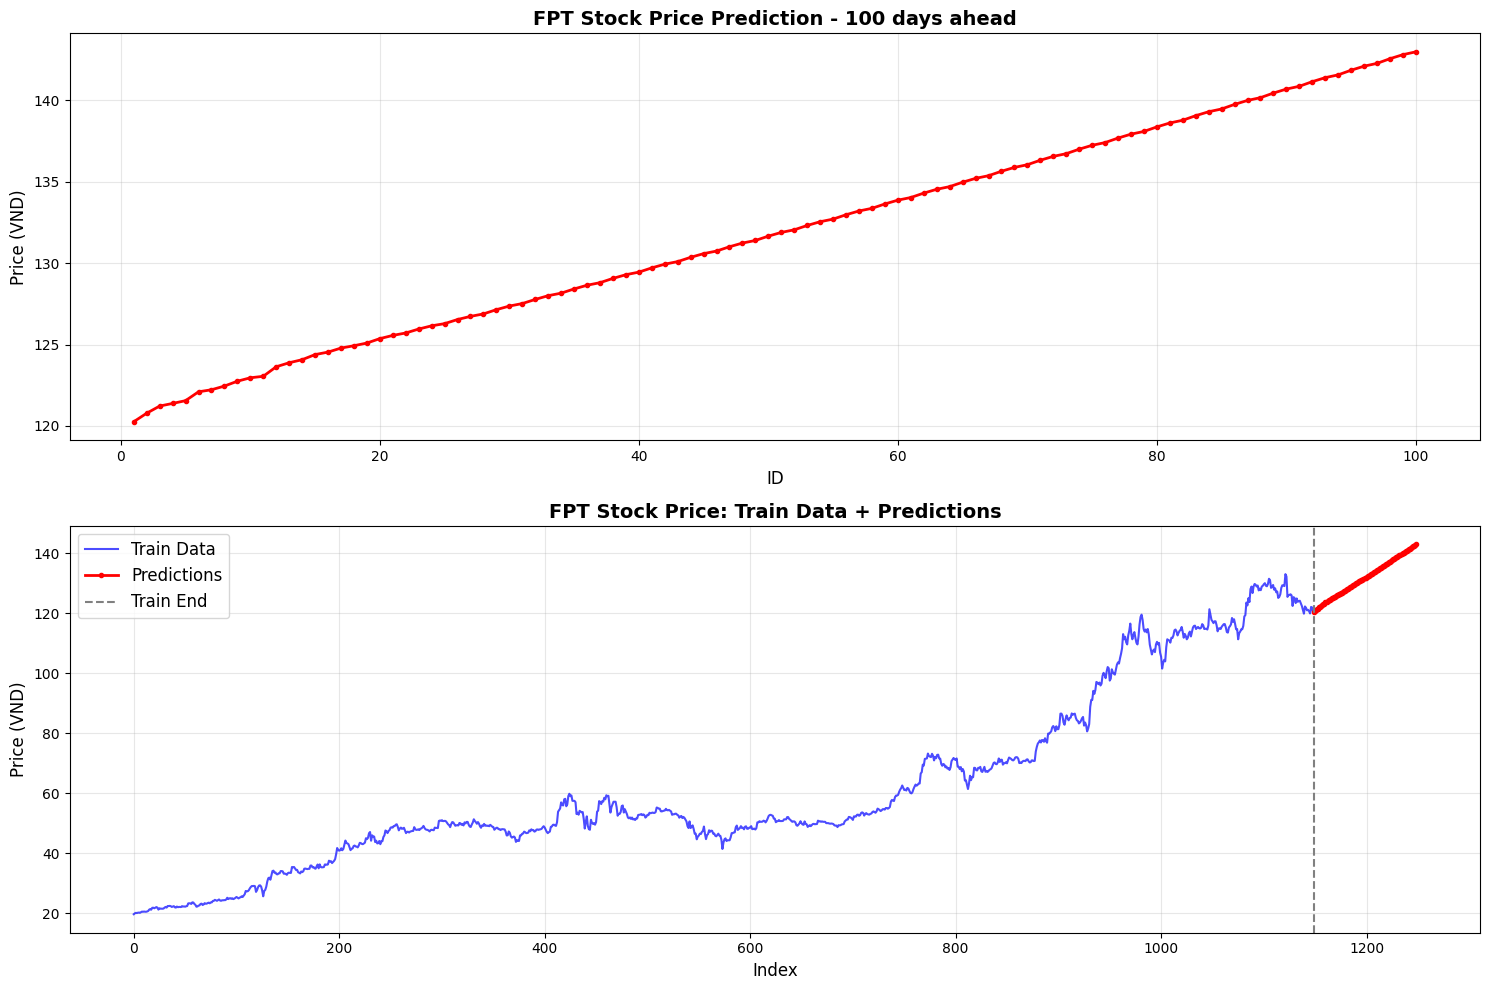

In [ ]:
# Visualization kết quả dự đoán
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Dự đoán 100 ngày tiếp theo
axes[0].plot(prediction_ids, predictions_close, linewidth=2, color='red', marker='o', markersize=3)
axes[0].set_title(f'FPT Stock Price Prediction - {TOTAL_PREDICT_DAYS} days ahead', fontsize=14, fontweight='bold')
axes[0].set_xlabel('ID', fontsize=12)
axes[0].set_ylabel('Price (VND)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Kết hợp train data và predictions
last_train_idx = len(df_train)
axes[1].plot(range(len(df_train)), df_train['close'], linewidth=1.5, color='blue', alpha=0.7, label='Train Data')
axes[1].plot(range(last_train_idx, last_train_idx + TOTAL_PREDICT_DAYS), predictions_close, linewidth=2, color='red', marker='o', markersize=3, label='Predictions')
axes[1].axvline(last_train_idx, color='gray', linestyle='--', linewidth=1.5, label='Train End')
axes[1].set_title('FPT Stock Price: Train Data + Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Index', fontsize=12)
axes[1].set_ylabel('Price (VND)', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1.  **MSE** ép model chọn giá trị trung bình (Mean).
2.  **Recursive** (Cuốn chiếu) giết chết phương sai (Variance Decay).

-----

#### Mô phỏng vấn đề 1

Giá trung bình thực tế: 100.2

=== KẾT QUẢ THI ĐẤU (MSE càng thấp càng tốt) ===
1. Model 'Bắt Đỉnh' (Đoán 110): MSE = 196.00
2. Model 'Random'   (Đoán bừa): MSE = 199.20
3. Model 'Trung Bình'(Đoán 100): MSE = 100.00  <-- VÔ ĐỊCH


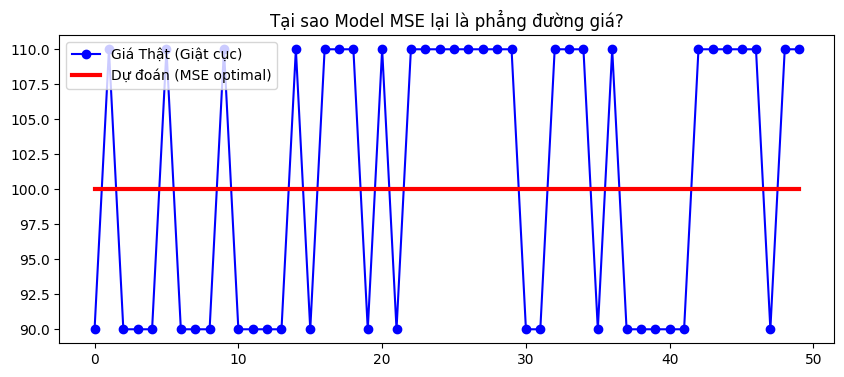

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. TẠO DỮ LIỆU THỊ TRƯỜNG BIẾN ĐỘNG (REALITY)
# Giả sử thị trường trong 1000 ngày tới cực kỳ giật cục:
# 50% số ngày giá là 90k (Giảm)
# 50% số ngày giá là 110k (Tăng)
np.random.seed(42)
true_prices = np.random.choice([90, 110], size=1000)

print(f"Giá trung bình thực tế: {true_prices.mean()}")

# 2. BA CHIẾN THUẬT DỰ ĐOÁN
# Chiến thuật 1: Model 'Bắt Đỉnh' (Luôn đoán giá sẽ lên 110)
pred_high = np.full(1000, 110)

# Chiến thuật 2: Model 'Trung Bình' (Luôn đoán giá ở giữa là 100 - MSE Logic)
pred_mean = np.full(1000, 100)

# Chiến thuật 3: Model 'Random' (Đoán bừa 90 hoặc 110)
pred_random = np.random.choice([90, 110], size=1000)

# 3. TÍNH ĐIỂM (MSE LOSS)
mse_high = np.mean((true_prices - pred_high)**2)
mse_mean = np.mean((true_prices - pred_mean)**2)
mse_random = np.mean((true_prices - pred_random)**2)

print("\n=== KẾT QUẢ THI ĐẤU (MSE càng thấp càng tốt) ===")
print(f"1. Model 'Bắt Đỉnh' (Đoán 110): MSE = {mse_high:.2f}")
print(f"2. Model 'Random'   (Đoán bừa): MSE = {mse_random:.2f}")
print(f"3. Model 'Trung Bình'(Đoán 100): MSE = {mse_mean:.2f}  <-- VÔ ĐỊCH")

# Vẽ hình minh họa
plt.figure(figsize=(10, 4))
plt.plot(true_prices[:50], label='Giá Thật (Giật cục)', color='blue', marker='o')
plt.plot(pred_mean[:50], label='Dự đoán (MSE optimal)', color='red', linewidth=3)
plt.title("Tại sao Model MSE lại là phẳng đường giá?")
plt.legend()
plt.show()

#### Mô phỏng vấn đề 2

`real_data` là một chuỗi giống hệt **giá cổ phiếu**:

* Đi lên xuống loạn xạ
* Không có xu hướng rõ rệt
* Không có seasonality
* Có variance lớn
* Chỉ có 1 tính chất: **tự cộng dồn từ nhiễu**

=> Mô hình phổ biến nhất cho thị trường tài chính.

---

* `noise` = độ giật mỗi ngày
* `cumsum` = cộng dồn các độ giật → tạo đường đi ngẫu nhiên
* `+100` = đặt giá ban đầu

→ Kết quả: **random walk**, tượng trưng cho giá FPT/VNINDEX.


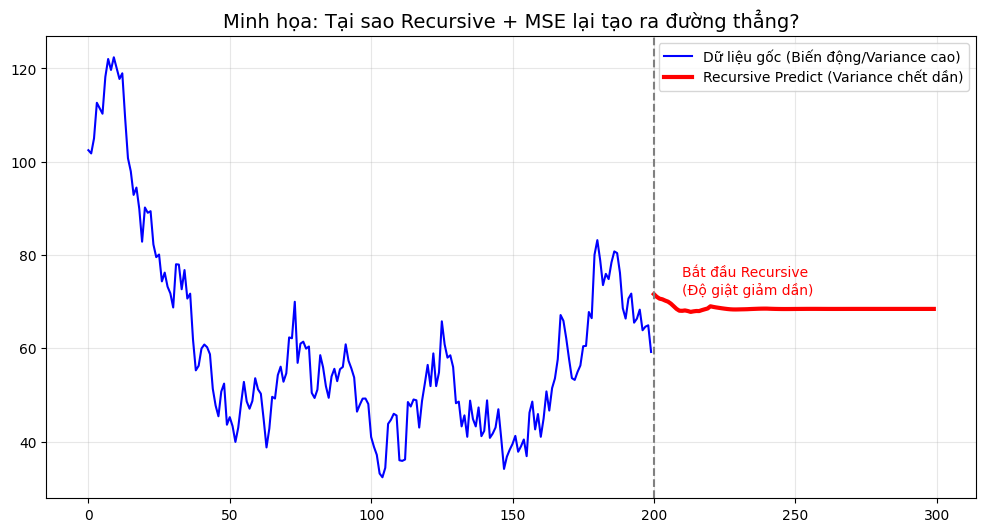

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. TẠO DỮ LIỆU (Có biến động mạnh - Shocks)
np.random.seed(42)
steps = 200 # sinh ra steps = 200 con số random theo phân phối chuẩn
# Giá đi random walk + noise mạnh
noise = np.random.normal(0, 5, steps)
real_data = np.cumsum(noise) + 100

# Ví dụ noise 5 ngày:
# Ngày 0: 100
# Ngày 1:  +4 -> 104
# Ngày 2:  -3 -> 101
# Ngày 3:  +2 -> 103
# Ngày 4:  +5
# Ngày 5:  -1

# Cumulative sum:
# Ngày 1: +4
# Ngày 2: +4 + (-3) = +1
# Ngày 3: +1 + 2 = +3
# Ngày 4: +3 + 5 = +8
# Ngày 5: +8 - 1 = +7

# -> random walk

# 100 là offset, đặt giá bắt đầu tại 100 -> → giống giá cổ phiếu hơn

# 2. MÔ PHỎNG MODEL (Học kiểu MSE)
# Giả sử Model học được là: "Giá ngày mai = Trung bình 10 ngày trước"
# Đây là model tối ưu nhất theo MSE nếu data là random walk
def mse_optimal_model(input_window):
    return np.mean(input_window)

# 3. CHẠY RECURSIVE (Cuốn chiếu)
# Lấy 20 ngày cuối làm input đầu vào
input_len = 20
current_input = list(real_data[-input_len:])
predictions = []

for _ in range(100): # Dự đoán 100 ngày tới
    # Bước A: Dự đoán (Ra con số trung bình)
    pred = mse_optimal_model(current_input)
    predictions.append(pred)

    # Bước B: Cuốn chiếu (Nhét con số trung bình vừa đoán vào input)
    current_input.pop(0) # Vứt ngày cũ nhất
    current_input.append(pred) # Nhét hàng "fake" (đã bị làm mượt) vào

# 4. VẼ HÌNH CHỨNG MINH
plt.figure(figsize=(12, 6))

# Vẽ data thật
plt.plot(range(steps), real_data, label='Dữ liệu gốc (Biến động/Variance cao)', color='blue')

# Vẽ data dự đoán
plt.plot(range(steps, steps + 100), predictions, label='Recursive Predict (Variance chết dần)', color='red', linewidth=3)

plt.title('Minh họa: Tại sao Recursive + MSE lại tạo ra đường thẳng?', fontsize=14)
plt.axvline(x=steps, color='gray', linestyle='--')
plt.text(steps + 10, predictions[0], 'Bắt đầu Recursive\n(Độ giật giảm dần)', color='red')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1\. Chứng minh: Tại sao MSE lại chọn Mean?

Bài toán là tìm một con số dự đoán $c$ sao cho sai số MSE là nhỏ nhất.

Giả sử giá ngày mai ($Y$) là một biến ngẫu nhiên (lúc tăng, lúc giảm). Ta cần tìm $c$ để hàm sau đạt cực tiểu:
$$Loss(c) = E[(Y - c)^2]$$

Bài toán TQ: Tìm giá trị dự đoán $\hat{y}$ (một hằng số) sao cho sai số MSE với biến ngẫu nhiên $Y$ là nhỏ nhất.

Hàm mục tiêu (Loss function):
$$L(\hat{y}) = \mathbb{E}[(Y - \hat{y})^2]$$

Triển khai hằng đẳng thức:
$$L(\hat{y}) = \mathbb{E}[Y^2 - 2Y\hat{y} + \hat{y}^2]$$
$$L(\hat{y}) = \mathbb{E}[Y^2] - 2\hat{y}\mathbb{E}[Y] + \hat{y}^2$$

Để tìm cực tiểu (Min), lấy đạo hàm theo $\hat{y}$ và cho bằng 0:
$$\frac{\partial L}{\partial \hat{y}} = -2\mathbb{E}[Y] + 2\hat{y} = 0$$

$$\Rightarrow 2\hat{y} = 2\mathbb{E}[Y]$$
$$\Rightarrow \mathbf{\hat{y} = \mathbb{E}[Y]}$$

**Kết luận:** Để MSE đạt min, giá trị dự đoán $\hat{y}$ **BẮT BUỘC phải là Kỳ vọng (Giá trị trung bình)** của dữ liệu.
$\rightarrow$ Model sẽ tự động bỏ qua các điểm cực trị (Outliers/Shocks) để chui vào vùng trung bình an toàn.

-----

### 2\. Hiệu ứng "Chết dần phương sai" (Variance Decay)

Khi ta kết hợp kết quả trên (Mean) vào vòng lặp Recursive, phương sai (độ biến động) sẽ giảm dần về 0.

Công thức truy hồi:
$$Input_{new} = \alpha \cdot Input_{old} + (1-\alpha) \cdot Mean$$
Mỗi lần model dự đoán, nó lấy trung bình, tức là nó làm "mượt" dữ liệu đi một chút. Qua 100 lần làm mượt, nó thành đường thẳng.



In [ ]:
# Tạo file CSV output với format: id, close
output_df = pd.DataFrame({
    'id': prediction_ids,
    'close': predictions_close
})

# Lưu file CSV
output_filename = 'submission.csv'
output_df.to_csv(output_filename, index=False)
print(f"Đã lưu file: {output_filename}")

Đã lưu file: submission.csv


In [ ]:
output_df

,id,close
0,1,120.261497
1,2,120.784370
2,3,121.223442
3,4,121.385117
4,5,121.555359
...,...,...
95,96,142.096344
96,97,142.269165
97,98,142.556549
98,99,142.804398


# **Improve**

## **1. Grid-search technical factors**

Ý tưởng:

* Định nghĩa một tập **cấu hình feature** (windows) cần thử.
* Với mỗi cấu hình:

  1. Build feature (return, momentum, volatility, z-score, long–short trend…)
  2. Split theo thời gian: train / val.
  3. Chuẩn hoá theo train, train MultiNLinear, đo **val MSE**.
* Chọn config nào có **val MSE nhỏ nhất** → coi là “optimum” trong class này.


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") # bịt miệng mấy cái cảnh báo đó lại cho màn hình sạch đẹp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### **1. MODEL + DATASET**

In [ ]:
# =========================
# 1. MODEL + DATASET
# =========================
class MultiFeatureDataset(Dataset):
    def __init__(self, X, y, seq_len=30, pred_len=3):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.X) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len, :]              # (seq_len, n_feat)
        y_seq = self.y[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return torch.tensor(x_seq), torch.tensor(y_seq)

In [ ]:
class MultiNLinear(nn.Module):
    def __init__(self, seq_len, n_feat, pred_len):
        super().__init__()
        self.seq_len = seq_len
        self.n_feat = n_feat
        self.linear = nn.Linear(seq_len * n_feat, pred_len)

    def forward(self, x):
        b = x.size(0)
        x_flat = x.reshape(b, self.seq_len * self.n_feat)
        return self.linear(x_flat)

In [ ]:
def train_one_config(X_train, y_train, X_val, y_val,
                     seq_len=30, pred_len=3,
                     batch_size=32, epochs=40, lr=1e-3):

    n_feat = X_train.shape[1]
    train_ds = MultiFeatureDataset(X_train, y_train, seq_len, pred_len)
    val_ds   = MultiFeatureDataset(X_val,   y_val,   seq_len, pred_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=True)

    model = MultiNLinear(seq_len, n_feat, pred_len).to(device)
    crit = nn.MSELoss()
    opt  = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            opt.zero_grad()
            preds = model(bx)
            loss = crit(preds, by)
            loss.backward()
            opt.step()

    # ---- compute val MSE ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)
            preds = model(bx)
            loss = crit(preds, by)
            val_losses.append(loss.item())
    val_mse = float(np.mean(val_losses)) if val_losses else np.inf
    return val_mse

#### **Minh họa**

In [ ]:
import numpy as np
import pandas as pd
import torch

# --- BƯỚC 1: DỮ LIỆU THÔ (NGUYÊN LIỆU) ---
# Giả sử có 4 ngày dữ liệu với 2 cột: Giá (Close) và Khối lượng (Volume)
data = {
    'Close':  [10, 20, 30, 40],
    'Volume': [100, 200, 300, 400]
}
df = pd.DataFrame(data)
print("1. Bảng dữ liệu gốc:")
print(df)
print("-" * 30)

1. Bảng dữ liệu gốc:
   Close  Volume
0     10     100
1     20     200
2     30     300
3     40     400
------------------------------


In [ ]:
# --- BƯỚC 2: DATASET (THỢ CẮT BÁNH) ---
# Giả sử cấu hình: Nhìn 2 ngày quá khứ (SEQ_LEN = 2)
# Dataset sẽ cắt ra mẫu đầu tiên (Ngày 0 và Ngày 1)
x_seq = df.values[0:2, :]

print("2. Output của Dataset (Miếng bánh được cắt ra):")
print(f"Shape: {x_seq.shape} (2 dòng, 2 cột)")
print("Giá trị:\n", x_seq)
print("\n-> Nhận xét: Đây là ma trận 2D, giữ nguyên cấu trúc bảng.")
print("-" * 30)

2. Output của Dataset (Miếng bánh được cắt ra):
Shape: (2, 2) (2 dòng, 2 cột)
Giá trị:
 [[ 10 100]
 [ 20 200]]

-> Nhận xét: Đây là ma trận 2D, giữ nguyên cấu trúc bảng.
------------------------------


In [ ]:
# --- BƯỚC 3: MODEL (MÁY XAY - FLATTEN) ---
# Model không ăn được ma trận 2D, nó cần 1 hàng ngang.
# Chuyển thành Tensor và giả lập 1 batch (Batch size = 1)
input_tensor = torch.tensor(x_seq).unsqueeze(0) # Shape: (1, 2, 2)

# Lệnh 'reshape' thần thánh: Đập bẹp ma trận thành vector
batch_size = input_tensor.size(0)
flattened = input_tensor.reshape(batch_size, -1) # -1 nghĩa là tự tính kích thước còn lại

print("3. Bên trong Model (Sau khi Flatten/Reshape):")
print(f"Shape cũ: {input_tensor.shape}")
print(f"Shape mới: {flattened.shape} (1 dòng, 4 số)")
print("Giá trị:\n", flattened)
print("\n-> Giải nghĩa: [Giá_ngày1, Vol_ngày1, Giá_ngày2, Vol_ngày2]")
print("-> Kết luận: Giờ thì model Linear có thể nhân trọng số w1, w2... với từng số này.")

3. Bên trong Model (Sau khi Flatten/Reshape):
Shape cũ: torch.Size([1, 2, 2])
Shape mới: torch.Size([1, 4]) (1 dòng, 4 số)
Giá trị:
 tensor([[ 10, 100,  20, 200]])

-> Giải nghĩa: [Giá_ngày1, Vol_ngày1, Giá_ngày2, Vol_ngày2]
-> Kết luận: Giờ thì model Linear có thể nhân trọng số w1, w2... với từng số này.


### **1.2. FEATURE ENGINEERING**

In [ ]:
# =========================
# 2. FEATURE ENGINEERING
# =========================
def build_features(df, cfg):
    """
    cfg: dict với các key:
      - 'ret_mid_window'
      - 'trend_window'
      - 'vol_window'
      - 'ma_short'
      - 'ma_long'
    Trả về df_feat (đã dropna) + list tên cột feature.
    """
    df = df.copy()
    df["close_log"] = np.log(df["close"])

    # Nhóm "Returns" (Tốc độ & Quán tính)
    # --- returns ---
    df["ret_1d"] = df["close_log"].diff(1) # Giá hôm nay trừ giá hôm qua
    df["ret_mid"] = df["close_log"].diff(cfg["ret_mid_window"]) # Giá hôm nay trừ giá tuần trước/tháng trước (tùy cách set cfg)

    # Nhóm "Trend & Volatility" (Xu hướng & Rủi ro)
    # --- trend & vol (rolling) ---
    tw = cfg["trend_window"]
    vw = cfg["vol_window"]
    df[f"ma_{tw}"]   = df["close_log"].rolling(tw).mean() # Tính đường trung bình trượt (MA)
    df[f"std_{vw}"]  = df["close_log"].rolling(vw).std() # Tính độ lệch chuẩn trong khoảng thời gian đó

    # --- z-score (detrended / standardized price) ---
    df["zscore_trend"] = (df["close_log"] - df[f"ma_{tw}"]) / df[f"std_{vw}"]
    # Công thức chuẩn hóa thống kê: (X - muy)/ xichma )Lấy (Giá - Giá trung bình) chia cho (Độ lệch chuẩn))


    # Nhóm "MA Cross" (Tín hiệu giao cắt): Tính 2 đường MA (ngắn hạn và dài hạn) rồi trừ cho nhau.
    # --- long-short trend (MA short vs long) ---
    ms, ml = cfg["ma_short"], cfg["ma_long"]
    df[f"ma_{ms}"] = df["close_log"].rolling(ms).mean()
    df[f"ma_{ml}"] = df["close_log"].rolling(ml).mean()
    df["ma_diff"]  = df[f"ma_{ms}"] - df[f"ma_{ml}"]

    # drop rows bị NaN do rolling/diff
    df = df.dropna().reset_index(drop=True)

    feature_cols = [
        "close_log",
        "ret_1d",
        "ret_mid",
        f"ma_{tw}",
        f"std_{vw}",
        "zscore_trend",
        f"ma_{ms}",
        f"ma_{ml}",
        "ma_diff",
    ]
    return df, feature_cols

# Đoạn code này biến đổi dữ liệu từ "Đơn điệu" (chỉ có Giá) sang "Đa chiều"

### **1.3. GRID SEARCH**

In [ ]:
# =========================
# 3. GRID SEARCH
# =========================
def grid_search_FPT(csv_path="FPT_train.csv",
                    train_ratio=0.7,
                    val_ratio=0.15,
                    seq_len=30,
                    pred_len=3):

    df = pd.read_csv(csv_path)
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").reset_index(drop=True)

    N = len(df)
    train_end = int(N * train_ratio)
    val_end   = int(N * (train_ratio + val_ratio))


    # build feature trên TRAIN + VAL riêng -> Tách riêng ra giúp mô phỏng đúng thực tế nhất
    df_train_raw = df.iloc[:train_end].copy()
    df_val_raw   = df.iloc[train_end:val_end].copy()

    # CÁC TẬP THAM SỐ CẦN THỬ
    ret_mid_list   = [3, 5, 10]          # momentum trung hạn
    trend_win_list = [7, 14, 21, 30]     # MA trend
    vol_win_list   = [7, 14, 21, 30]     # volatility window
    ma_pairs       = [(7, 30), (14, 50), (20, 60)]

    configs = []
    for rm in ret_mid_list:
        for tw in trend_win_list:
            for vw in vol_win_list:
                for ms, ml in ma_pairs:
                    if ms >= ml:
                        continue
                    configs.append({
                        "ret_mid_window": rm,
                        "trend_window": tw,
                        "vol_window": vw,
                        "ma_short": ms,
                        "ma_long": ml,
                    })

    best_cfg = None
    best_mse = np.inf

    for i, cfg in enumerate(configs, 1):
        print(f"\n=== Config {i}/{len(configs)}: {cfg} ===")

        # build feature trên TRAIN + VAL riêng (để không leak)
        df_train_feat, feat_cols = build_features(df_train_raw, cfg)
        df_val_feat,   _         = build_features(df_val_raw,   cfg)

        if len(df_train_feat) < seq_len + pred_len + 10 or len(df_val_feat) < seq_len + pred_len + 10:
            print("  -> too short after rolling/diff, skip")
            continue

        # chuẩn hóa (fit trên train)
        X_train_raw = df_train_feat[feat_cols].values.astype(np.float32)
        y_train_raw = df_train_feat["close_log"].values.astype(np.float32).reshape(-1, 1)

        X_val_raw   = df_val_feat[feat_cols].values.astype(np.float32)
        y_val_raw   = df_val_feat["close_log"].values.astype(np.float32).reshape(-1, 1)

        scaler_X = StandardScaler().fit(X_train_raw)
        scaler_y = StandardScaler().fit(y_train_raw)

        X_train = scaler_X.transform(X_train_raw).astype(np.float32)
        y_train = scaler_y.transform(y_train_raw).astype(np.float32).flatten()

        X_val   = scaler_X.transform(X_val_raw).astype(np.float32)
        y_val   = scaler_y.transform(y_val_raw).astype(np.float32).flatten()

        # train & validate
        val_mse = train_one_config(
            X_train, y_train,
            X_val,   y_val,
            seq_len=seq_len,
            pred_len=pred_len,
            batch_size=32,
            epochs=40,
            lr=1e-3
        )

        print(f"  -> Val MSE: {val_mse:.6f}")

        if val_mse < best_mse:
            best_mse = val_mse
            best_cfg = cfg

    print("\n========================")
    print("BEST CONFIG:", best_cfg)
    print("BEST VAL MSE:", best_mse)
    print("========================")
    return best_cfg, best_mse

# GỌI GRID-SEARCH LUÔN ĐỂ LẤY best_cfg DÙNG CHO PHẦN 2
best_cfg, best_mse = grid_search_FPT("FPT_train.csv")
print("Using BEST CONFIG for pipeline:", best_cfg)


=== Config 1/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 7, 'ma_short': 7, 'ma_long': 30} ===
  -> Val MSE: 0.010014

=== Config 2/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 7, 'ma_short': 14, 'ma_long': 50} ===
  -> Val MSE: 0.011001

=== Config 3/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 7, 'ma_short': 20, 'ma_long': 60} ===
  -> Val MSE: 0.014493

=== Config 4/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 14, 'ma_short': 7, 'ma_long': 30} ===
  -> Val MSE: 0.013391

=== Config 5/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 14, 'ma_short': 14, 'ma_long': 50} ===
  -> Val MSE: 0.013951

=== Config 6/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 14, 'ma_short': 20, 'ma_long': 60} ===
  -> Val MSE: 0.016122

=== Config 7/144: {'ret_mid_window': 3, 'trend_window': 7, 'vol_window': 21, 'ma_short': 7, 'ma_long': 30} ===
  -> Val MSE: 0.014300

=== Config 8/144: {'ret_mid_window': 3, 'trend_window

Cái script này:

* Bao phủ các nhóm:

  * **return**: `ret_1d`, `ret_mid`
  * **momentum**: `ret_mid` chính là động lượng trung hạn
  * **volatility**: `std_{vw}`
  * **detrended / z-score**: `zscore_trend`
  * **long–short trend**: `ma_short`, `ma_long`, `ma_diff`
* Tự động scan nhiều tổ hợp (`3 × 4 × 4 × 3` cấu hình, bớt mấy cái ms ≥ ml)
* Trả ra **config tốt nhất** theo validation MSE.

Ta có thể lấy `best_cfg` rồi nhét lại vào pipeline forecast 100 ngày.


In [ ]:
# Thông số khiến MSE đạt 35.9
# ========================
# BEST CONFIG: {'ret_mid_window': 5, 'trend_window': 30, 'vol_window': 30, 'ma_short': 7, 'ma_long': 30}
# BEST VAL MSE: 0.007910789300998053
# ========================
# Using BEST CONFIG for pipeline: {'ret_mid_window': 5, 'trend_window': 30, 'vol_window': 30, 'ma_short': 7, 'ma_long': 30}

## **2. Pipeline code**

In [ ]:
best_cfg

{'ret_mid_window': 5,
 'trend_window': 14,
 'vol_window': 30,
 'ma_short': 7,
 'ma_long': 30}

In [ ]:
best_cfg['ret_mid_window'] = 5
best_cfg['trend_window'] = 30
best_cfg['vol_window'] = 30
best_cfg['ma_short'] = 7
best_cfg['ma_long'] = 30

### **2.1. IMPORT & CẤU HÌNH**

In [ ]:
# ============================================
# 1. IMPORT & CẤU HÌNH
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ===== THAM SỐ CẤU HÌNH =====
INPUT_LEN = 40#30            # số ngày quá khứ
OUTPUT_LEN = 4#3            # dự đoán 3 ngày mỗi lần
TOTAL_PREDICT_DAYS = 100  # dự đoán tổng 100 ngày
BATCH_SIZE = 128
NUM_EPOCHS = 60
LEARNING_RATE = 5e-4#1e-3

TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15   # còn lại là test

# ===== LẤY THAM SỐ KỸ THUẬT TỪ GRID-SEARCH Ở PHẦN 1 =====
RET_MID   = best_cfg["ret_mid_window"]   # ví dụ 10
TREND_WIN = best_cfg["trend_window"]     # ví dụ 21
VOL_WIN   = best_cfg["vol_window"]       # ví dụ 30
MA_SHORT  = best_cfg["ma_short"]         # ví dụ 7
MA_LONG   = best_cfg["ma_long"]          # ví dụ 30

print("RET_MID =", RET_MID,
      "| TREND_WIN =", TREND_WIN,
      "| VOL_WIN =", VOL_WIN,
      "| MA_SHORT =", MA_SHORT,
      "| MA_LONG =", MA_LONG)

Torch version: 2.9.0+cu126
Device: cuda
RET_MID = 5 | TREND_WIN = 30 | VOL_WIN = 30 | MA_SHORT = 7 | MA_LONG = 30


### **2.2. LOAD DATA & FEATURE ENGINEERING**

In [ ]:
# ============================================
# 2. LOAD DATA & FEATURE ENGINEERING
# ============================================
df = pd.read_csv("FPT_train.csv")

# Chuẩn hóa time & sort
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)

print("Raw df shape:", df.shape)
print(df.head())

# ----- 2.1. Log-price -----
df["close_log"] = np.log(df["close"])

# ----- 2.2. Feature kỹ thuật từ log-price (dùng BEST CONFIG động) -----
# Tên cột giờ chỉ là “nhãn”, chưa chắc đúng con số, nhưng chạy thì vẫn ok
# momentum
df["return_1d"]  = df["close_log"].diff(1)
df[f"return_{RET_MID}d"] = df["close_log"].diff(RET_MID)   # dùng ret_mid_window tốt nhất

# trend & volatility
df[f"rolling_mean_{TREND_WIN}"] = df["close_log"].rolling(TREND_WIN).mean()  # trend_window

df[f"rolling_std_{VOL_WIN}"]  = df["close_log"].rolling(VOL_WIN).std()     # vol_window

# long–short trend MA_short / MA_long
df[f"ma_{MA_SHORT}"]  = df["close_log"].rolling(MA_SHORT).mean()
df[f"ma_{MA_LONG}"] = df["close_log"].rolling(MA_LONG).mean()
df["ma_diff"] = df[f"ma_{MA_SHORT}"] - df[f"ma_{MA_LONG}"]

# z-score trên trend/vol
df["zscore_trend"] = (df["close_log"] - df[f"rolling_mean_{TREND_WIN}"]) / df[f"rolling_std_{VOL_WIN}"]

# Do diff & rolling nên vài dòng đầu bị NaN -> bỏ
df = df.dropna().reset_index(drop=True)
print("After feature engineering & dropna:", df.shape)

Raw df shape: (1149, 7)
        time   open   high    low  close   volume symbol
0 2020-08-03  19.07  19.63  19.03  19.63  1392200    FPT
1 2020-08-04  19.89  20.01  19.76  19.91  1051310    FPT
2 2020-08-05  19.89  20.16  19.78  20.10  1328520    FPT
3 2020-08-06  20.10  20.21  19.97  20.01  1153660    FPT
4 2020-08-07  20.01  20.44  20.01  20.14  1283690    FPT
After feature engineering & dropna: (1120, 16)


### **2.3. SPLIT TRÊN DF GỐC + CHUẨN HÓA**

In [ ]:
# ============================================
# 3. SPLIT TRÊN DF GỐC + CHUẨN HÓA
# ============================================
feature_cols = [
    "close_log",
    "return_1d",
    f"return_{RET_MID}d",
    f"rolling_mean_{TREND_WIN}",
    f"rolling_std_{VOL_WIN}",
    f"ma_{MA_SHORT}",
    f"ma_{MA_LONG}",
    "ma_diff",
    "zscore_trend"
]
target_col = "close_log"

N_all = len(df)
train_end = int(N_all * TRAIN_RATIO)
val_end   = int(N_all * (TRAIN_RATIO + VAL_RATIO))

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

print(f"Rows -> Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

# Lấy raw X, y cho từng phần
X_train_raw = df_train[feature_cols].values.astype(np.float32)
y_train_raw = df_train[target_col].values.astype(np.float32).reshape(-1, 1)

X_val_raw   = df_val[feature_cols].values.astype(np.float32)
y_val_raw   = df_val[target_col].values.astype(np.float32).reshape(-1, 1)

X_test_raw  = df_test[feature_cols].values.astype(np.float32)
y_test_raw  = df_test[target_col].values.astype(np.float32).reshape(-1, 1)

# --- Fit scaler CHỈ trên train ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(X_train_raw)
scaler_y.fit(y_train_raw)

# --- Transform tất cả bằng scaler train ---
X_train = scaler_X.transform(X_train_raw).astype(np.float32)
y_train = scaler_y.transform(y_train_raw).astype(np.float32).flatten()

X_val   = scaler_X.transform(X_val_raw).astype(np.float32)
y_val   = scaler_y.transform(y_val_raw).astype(np.float32).flatten()

X_test  = scaler_X.transform(X_test_raw).astype(np.float32)
y_test  = scaler_y.transform(y_test_raw).astype(np.float32).flatten()

N_FEAT = X_train.shape[1]
print("n_feat:", N_FEAT)

Rows -> Train: 784, Val: 168, Test: 168
n_feat: 9


### **2.4. DATASET MULTIVARIATE (TRÊN TỪNG ĐOẠN)**

In [ ]:
# ============================================
# 4. DATASET MULTIVARIATE (TRÊN TỪNG ĐOẠN)
# ============================================
class MultiFeatureDataset(Dataset):
    """
    Dataset đa biến:
    - X_norm: (N, n_feat)
    - y_norm: (N,)
    Trả về:
    - x_seq: (seq_len, n_feat)
    - y_seq: (pred_len,)
    """
    def __init__(self, X_norm, y_norm, seq_len=30, pred_len=3):
        self.X = np.asarray(X_norm, dtype=np.float32)
        self.y = np.asarray(y_norm, dtype=np.float32)
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        # số window hợp lệ trong đoạn này
        return len(self.X) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len, :]  # (seq_len, n_feat)
        y_seq = self.y[idx + self.seq_len : idx + self.seq_len + self.pred_len]  # (pred_len,)
        return torch.tensor(x_seq), torch.tensor(y_seq)

train_ds = MultiFeatureDataset(X_train, y_train, seq_len=INPUT_LEN, pred_len=OUTPUT_LEN)
val_ds   = MultiFeatureDataset(X_val,   y_val,   seq_len=INPUT_LEN, pred_len=OUTPUT_LEN)
test_ds  = MultiFeatureDataset(X_test,  y_test,  seq_len=INPUT_LEN, pred_len=OUTPUT_LEN)

print(f"Sliding samples -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Sliding samples -> Train: 741, Val: 125, Test: 125


### **2.5. MODEL MULTI-NLINEAR**

In [ ]:
# ============================================
# 5. MODEL MULTI-NLINEAR
# ============================================
class MultiNLinear(nn.Module):
    """
    Multi-variate phiên bản đơn giản:
    - Input: [batch, seq_len, n_feat]
    - Flatten (seq_len * n_feat) -> Linear -> pred_len
    """
    def __init__(self, seq_len, n_feat, pred_len):
        super(MultiNLinear, self).__init__()
        self.seq_len = seq_len
        self.n_feat = n_feat
        self.pred_len = pred_len

        self.linear = nn.Linear(seq_len * n_feat, pred_len)

    def forward(self, x):
        # x: [batch, seq_len, n_feat]
        batch_size = x.size(0)
        x_flat = x.reshape(batch_size, self.seq_len * self.n_feat)
        out = self.linear(x_flat)           # (batch, pred_len)
        return out

model = MultiNLinear(seq_len=INPUT_LEN, n_feat=N_FEAT, pred_len=OUTPUT_LEN).to(device)
print(model)

MultiNLinear(
  (linear): Linear(in_features=360, out_features=4, bias=True)
)


### **2.6. TRAINING LOOP**

Epoch 001/60 | Train Loss: 0.880034 | Val Loss: 3.277167
Epoch 002/60 | Train Loss: 0.422674 | Val Loss: 1.649182
Epoch 003/60 | Train Loss: 0.239008 | Val Loss: 0.728158
Epoch 004/60 | Train Loss: 0.139825 | Val Loss: 0.264913
Epoch 005/60 | Train Loss: 0.103690 | Val Loss: 0.125823
Epoch 006/60 | Train Loss: 0.088170 | Val Loss: 0.093055
Epoch 007/60 | Train Loss: 0.072237 | Val Loss: 0.068003
Epoch 008/60 | Train Loss: 0.060410 | Val Loss: 0.056579
Epoch 009/60 | Train Loss: 0.050960 | Val Loss: 0.054268
Epoch 010/60 | Train Loss: 0.046519 | Val Loss: 0.055711
Epoch 011/60 | Train Loss: 0.041741 | Val Loss: 0.052273
Epoch 012/60 | Train Loss: 0.036824 | Val Loss: 0.046115
Epoch 013/60 | Train Loss: 0.032374 | Val Loss: 0.043012
Epoch 014/60 | Train Loss: 0.030121 | Val Loss: 0.042986
Epoch 015/60 | Train Loss: 0.027122 | Val Loss: 0.041308
Epoch 016/60 | Train Loss: 0.024935 | Val Loss: 0.038845
Epoch 017/60 | Train Loss: 0.023498 | Val Loss: 0.033446
Epoch 018/60 | Train Loss: 0.02

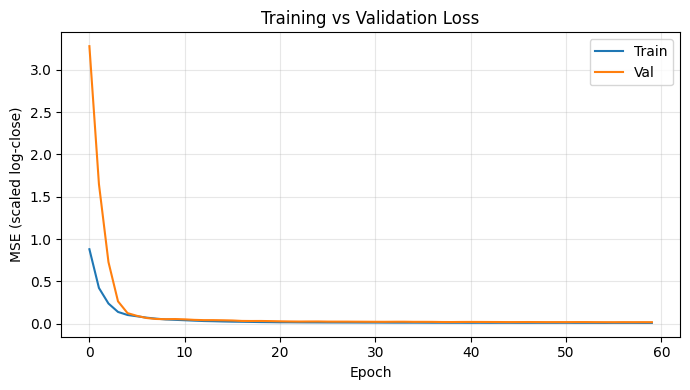

In [ ]:
# ============================================
# 6. TRAINING LOOP
# ============================================
def train_model(model, train_loader, val_loader, num_epochs=60, lr=1e-3, device="cpu"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)          # (B, seq_len, n_feat)
            batch_y = batch_y.to(device)          # (B, pred_len)

            optimizer.zero_grad()
            preds = model(batch_x)                # (B, pred_len)
            loss = criterion(preds, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= max(1, len(train_loader))

        # ---- VALIDATION ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                val_loss += loss.item()
        val_loss /= max(1, len(val_loader))

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1:03d}/{num_epochs} | "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        scheduler.step()

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,
    device=device
)

# (Optional) Vẽ loss
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled log-close)")
plt.title("Training vs Validation Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### **2.7. EVALUATE TRÊN TẬP TEST (THANG GIÁ THẬT)**

In [ ]:
# ============================================
# 7. EVALUATE TRÊN TẬP TEST (THANG GIÁ THẬT)
# ============================================
def evaluate_on_test(model, test_loader, scaler_y, device="cpu"):
    model.eval()
    preds_price, reals_price = [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)          # scaled log-close

            outputs = model(batch_x)              # scaled log-close (B, pred_len)

            for i in range(outputs.shape[0]):
                # p = Prediction (Dự đoán)
                # r = Real (Thực tế)
                p_scaled = outputs[i].cpu().numpy().reshape(-1, 1)
                r_scaled = batch_y[i].cpu().numpy().reshape(-1, 1)

                # inverse-scaling to log-close
                p_log = scaler_y.inverse_transform(p_scaled).flatten()
                r_log = scaler_y.inverse_transform(r_scaled).flatten()

                # log-close -> price
                p_price = np.exp(p_log)
                r_price = np.exp(r_log)

                preds_price.extend(p_price)
                reals_price.extend(r_price)

                # đặt p và r song song nhau (p_log vs r_log, p_price vs r_price) là để tiện so sánh đối chiếu từng cặp một

    preds_price = np.array(preds_price)
    reals_price = np.array(reals_price)

    mse = mean_squared_error(reals_price, preds_price)
    mae = mean_absolute_error(reals_price, preds_price)
    rmse = np.sqrt(mse)
    r2 = r2_score(reals_price, preds_price)

    print(f"TEST  -> RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return preds_price, reals_price

_ = evaluate_on_test(model, test_loader, scaler_y, device=device)

TEST  -> RMSE: 4.0909 | MAE: 3.2006 | R2: 0.5544


### **2.8. RECURSIVE FORECAST 100 NGÀY TỚI**

In [ ]:
# ============================================
# 8. RECURSIVE FORECAST 100 NGÀY TỚI
# ============================================

def append_new_row_with_features(df_feat, close_log_new):
    """
    df_feat: DataFrame hiện tại đã có các cột feature_cols + close_log.
    close_log_new: log-price mới dự đoán.
    Trả về df_feat (copy) sau khi append 1 row với feature tương ứng.
    """
    df_tmp = df_feat.copy()
    idx_new = len(df_tmp)

    row = {}
    row["close_log"] = close_log_new

    # return_1d
    log_prev = df_tmp["close_log"].iloc[-1]
    row["return_1d"] = close_log_new - log_prev

    # return_mid với window RET_MID
    if idx_new >= RET_MID:
        log_prev_mid = df_tmp["close_log"].iloc[-RET_MID]
        row[f"return_{RET_MID}d"] = close_log_new - log_prev_mid
    else:
        row[f"return_{RET_MID}d"] = row["return_1d"]

    # tạm append row để tính rolling
    df_tmp = pd.concat([df_tmp, pd.DataFrame([row])], ignore_index=True)

    # rolling_mean_{TREND_WIN} (dùng TREND_WIN điểm cuối, hoặc ít hơn nếu đầu chuỗi)
    df_tmp.loc[idx_new, f"rolling_mean_{TREND_WIN}"] = (
        df_tmp["close_log"].iloc[max(0, idx_new - (TREND_WIN - 1)) : idx_new+1].mean()
    )

    # rolling_std_{VOL_WIN} (VOL_WIN)
    df_tmp.loc[idx_new, f"rolling_std_{VOL_WIN}"] = (
        df_tmp["close_log"].iloc[max(0, idx_new - (VOL_WIN - 1)) : idx_new+1].std(ddof=0)
    )

    # ma_{MA_SHORT} và ma_{MA_LONG}
    df_tmp.loc[idx_new, f"ma_{MA_SHORT}"] = (
        df_tmp["close_log"].iloc[max(0, idx_new - (MA_SHORT - 1)) : idx_new+1].mean()
    )
    df_tmp.loc[idx_new, f"ma_{MA_LONG}"] = (
        df_tmp["close_log"].iloc[max(0, idx_new - (MA_LONG - 1)) : idx_new+1].mean()
    )
    df_tmp.loc[idx_new, "ma_diff"] = df_tmp.loc[idx_new, f"ma_{MA_SHORT}"] - df_tmp.loc[idx_new, f"ma_{MA_LONG}"]

    # zscore_trend
    mean = df_tmp.loc[idx_new, f"rolling_mean_{TREND_WIN}"]
    std  = df_tmp.loc[idx_new, f"rolling_std_{VOL_WIN}"]
    if (std is None) or np.isnan(std) or std == 0:
        df_tmp.loc[idx_new, "zscore_trend"] = 0.0
    else:
        df_tmp.loc[idx_new, "zscore_trend"] = (close_log_new - mean) / std

    return df_tmp


def recursive_forecast_multivar(model, df_hist, feature_cols, scaler_X, scaler_y,
                                seq_len, pred_len, total_days, device="cpu"):
    """
    df_hist: DataFrame đã có các cột feature_cols (close_log + feature).
    Trả về mảng giá dự đoán (len = total_days) trong THANG GIÁ THẬT.
    """
    model.eval()
    df_future = df_hist.copy()
    preds_price_all = []

    with torch.no_grad():
        while len(preds_price_all) < total_days:
            X_window_raw = df_future[feature_cols].iloc[-seq_len:].values.astype(np.float32)
            X_window_norm = scaler_X.transform(X_window_raw)

            x_tensor = torch.tensor(X_window_norm, dtype=torch.float32).unsqueeze(0).to(device)
            y_pred_scaled = model(x_tensor).cpu().numpy().flatten()  # (pred_len,)

            for y_s in y_pred_scaled:
                if len(preds_price_all) >= total_days:
                    break

                # scaled -> log-close
                y_log = scaler_y.inverse_transform([[y_s]]).flatten()[0]
                # log-close -> price thực
                y_price = float(np.exp(y_log))
                preds_price_all.append(y_price)

                # cập nhật df_future với điểm mới
                df_future = append_new_row_with_features(df_future, y_log)

    return np.array(preds_price_all), df_future

In [ ]:
# dùng toàn bộ df (đã có feature) làm lịch sử để forecast
df_hist_for_future = df[feature_cols].copy()

future_prices, df_all = recursive_forecast_multivar(
    model,
    df_hist=df_hist_for_future,
    feature_cols=feature_cols,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    seq_len=INPUT_LEN,
    pred_len=OUTPUT_LEN,
    total_days=TOTAL_PREDICT_DAYS,
    device=device
)

print("Future prices (first 10):", future_prices[:10])

Future prices (first 10): [116.64468459 112.69067141 119.34810403 120.17484687 117.10703937
 117.57616901 117.28441008 115.45582605 112.06778105 112.71552013]


### **2.9. VẼ PLOT & TẠO SUBMISSION**

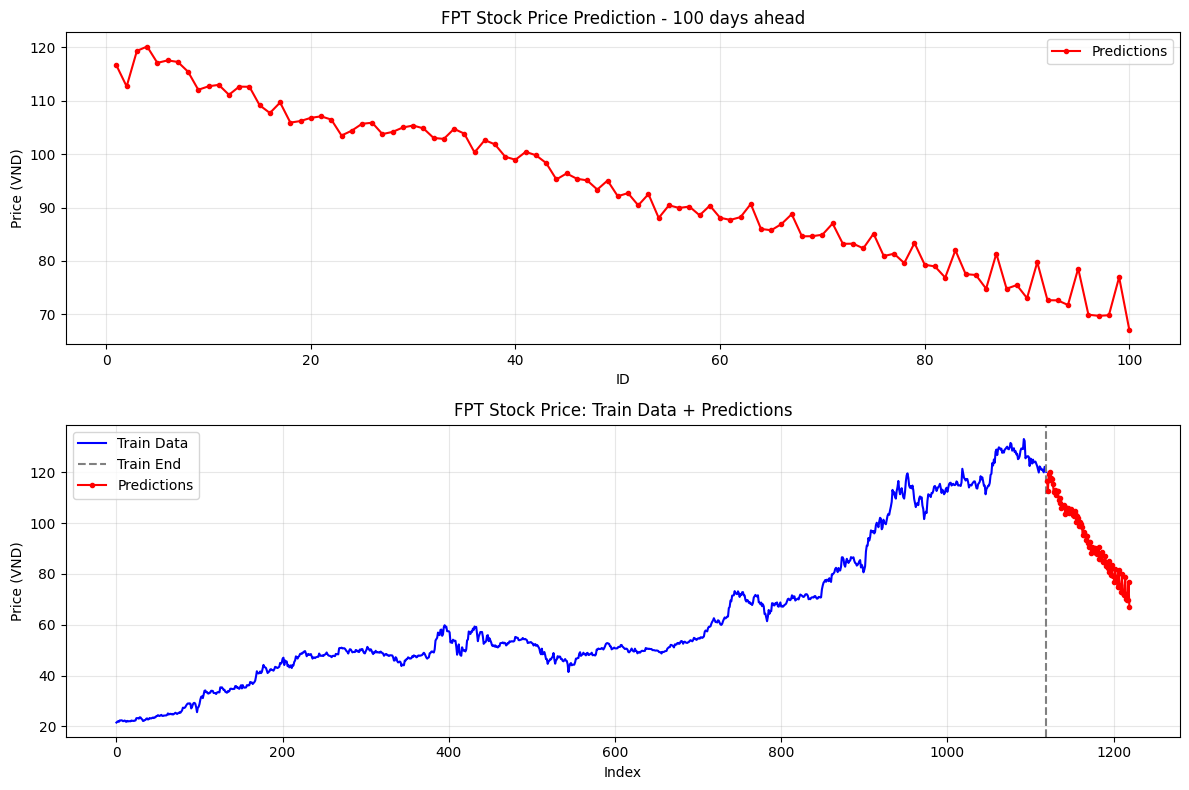

Saved submission.csv ✅


In [ ]:
# ============================================
# 9. VẼ PLOT & TẠO SUBMISSION
# ============================================
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(range(1, TOTAL_PREDICT_DAYS+1), future_prices, "r-o", markersize=3, label="Predictions")
plt.title("FPT Stock Price Prediction - 100 days ahead")
plt.xlabel("ID")
plt.ylabel("Price (VND)")
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(2,1,2)
plt.plot(df["close"].values, label="Train Data", color="blue")
train_end_idx = len(df) - 1
plt.axvline(train_end_idx, linestyle="--", color="gray", label="Train End")

pred_index = np.arange(train_end_idx+1, train_end_idx+1+TOTAL_PREDICT_DAYS)
plt.plot(pred_index, future_prices, "r-o", markersize=3, label="Predictions")

plt.title("FPT Stock Price: Train Data + Predictions")
plt.xlabel("Index")
plt.ylabel("Price (VND)")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

submission = pd.DataFrame({
    "id": np.arange(1, TOTAL_PREDICT_DAYS + 1),
    "close": future_prices
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv ✅")

In [ ]:
print(f"Sliding samples -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Sliding samples -> Train: 741, Val: 125, Test: 125


### 1. Pipeline xử lý Level Shift như thế nào? (Khi giá nhảy từ 80 lên 120)

Thực tế, pipeline này xử lý Level Shift bằng chiến thuật **"Triệt tiêu rồi Tái tạo" (Remove & Reconstruct)**. Nó không dạy model học giá trị tuyệt đối (80k hay 120k), mà dạy model học **sự biến động tương đối**.

Cụ thể trong code `improve.txt`:

* **Bước 1: Triệt tiêu Level (Làm phẳng dữ liệu)**
    Trong hàm `build_features`, mày sẽ thấy nó tạo ra các features này:
    * **Return (`ret_1d`, `ret_mid`):** $R_t = \log(P_t) - \log(P_{t-1})$. Đây là đạo hàm bậc 1 của giá. Dù giá FPT có là 10k hay 100k, thì biến động 1% vẫn là con số `0.01`. Nó đưa dữ liệu về dạng dừng (Stationary).
    * **Z-score (`zscore_trend`)**: $Z_t = \frac{P_t - MA}{\sigma}$. Nó ép giá trị về độ lệch chuẩn so với đường trung bình. Dù giá đang ở đỉnh cao hay đáy vực, model chỉ nhìn thấy $Z_t$ nằm trong khoảng `[-2, 2]`.
    * **StandardScaler**: Sau đó toàn bộ Input `X` được scale tiếp một lần nữa về mean=0, std=1.

    $\rightarrow$ **Kết quả:** Model **Không QUAN TÂM** giá đang là bao nhiêu. Nó chỉ quan tâm: *"Hôm nay biến động bao nhiêu sigma so với hôm qua?"*.

* **Bước 2: Tái tạo Level (Khi dự đoán)**
    Trong hàm `recursive_forecast_multivar`:
    * Model nhả ra `y_s` (giá trị đã scale/triệt tiêu level).
    * Code dùng `scaler_y.inverse_transform` để khôi phục lại mức giá gốc (Log-scale).
    * Sau đó `np.exp(y_log)` để ra giá thật.

**Tóm lại:** Nó xử lý Level Shift bằng cách **"Relativization" (Tương đối hóa)**. Input vào model là tương đối, nên model không bị ngáo khi giá nhảy lên mức level mới mà nó chưa từng thấy trong tập train.

---

### 2. Phân tích Toán học về Recursive (Tại sao nó sống được?)

Cái `recursive_forecast_multivar` trong `improve.txt` không phải là đệ quy đơn thuần (Simple Autoregression) kiểu ARIMA, mà nó là một hệ thống **Dynamic State Update (Cập nhật trạng thái động)**.

Hãy nhìn vào bản chất toán học của nó thông qua hàm `append_new_row_with_features`:

Gọi $S_t$ là vectơ trạng thái (Feature vector) tại thời điểm $t$.
$$S_t = [\text{Price}_t, \text{Trend}_t, \text{Vol}_t, \text{Momentum}_t]$$

**Trong Baseline (Chết yểu):**
$$P_{t+1} = Model(P_t, P_{t-1}, ...)$$
Model chỉ nhận đầu vào là giá. Khi $P_{t+1}$ hội tụ về trung bình, chuỗi input trở thành hằng số $\rightarrow$ Output nằm im.

**Trong Improve (Sống khỏe - thậm chí quá khỏe):**
Hệ phương trình hoạt động như sau:

1.  **Prediction:** $\hat{P}_{t+1} = Model(S_t)$
2.  **State Reconstruction:**
* **Momentum (Return)**

  $$
  \text{Momentum}_{t+1} = \hat{P}_{t+1} - \hat{P}_t
  $$

* **Trend (Moving Average Update)**

  $$
  \text{Trend}_{t+1} = \text{UpdateMA}(\text{Trend}_t, \hat{P}_{t+1})
  $$

* **MA Spread (Độ doãng MA)**

  $$
  \text{Diff}_{t+1} = \text{TrendShort}_{t+1} - \text{TrendLong}_{t+1}
  $$

3.  **Next Step:** $\hat{P}_{t+2} = Model(S_{t+1})$

**Tại sao nó thuyết phục?**
Nó tạo ra một **Hệ phương trình vi phân sai phân (Difference Equation System)**.

Giả sử model học được trọng số dương cho Feature `ma_diff` (tức là MA ngắn nằm trên MA dài $\rightarrow$ Giá tăng).
* Nếu $P_{t+1}$ tăng nhẹ $\rightarrow$ `ma_diff` tại $t+1$ tăng lên $\epsilon$.
* Tại bước $t+2$, input đầu vào có `ma_diff` lớn hơn $\rightarrow$ Model (Linear) nhân trọng số dương vào $\rightarrow$ Output $\hat{P}_{t+2}$ tăng mạnh hơn.
* $\hat{P}_{t+2}$ tăng mạnh $\rightarrow$ `ma_diff` tại $t+2$ lại càng doãng rộng ra.

$\rightarrow$ **Kết luận:** Đây là cơ chế **Positive Feedback Loop (Phản hồi dương)**. Toán học của nó đảm bảo rằng chỉ cần một "mồi lửa" (quán tính ban đầu), hệ thống sẽ tự duy trì động năng (Momentum) thông qua việc *liên tục cập nhật các biến phái sinh* (Trend, Volatility) thay vì chỉ ném lại giá trị thô.

Đó là lý do tại sao code `improve.txt` vẽ được đường dự đoán có xu hướng rõ rệt, trong khi baseline thì cắm đầu xuống đất (Mean Reversion).